In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision as tv
from torch.cuda.amp import autocast, GradScaler

import cv2

from tqdm.auto import tqdm

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
!pip install kaggle
from google.colab import files
if 'kaggle.json' not in os.listdir():
  files.upload() #API token
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download 'tongpython/cat-and-dog'
!unzip 'cat-and-dog.zip'

## Dataset

In [4]:
class Dataset2class(torch.utils.data.Dataset):
  def __init__(self, path1:str, path2:str, size=64):
    super().__init__()
    self.path1 = path1
    self.path2 = path2
    self.size = size

    self.list1 = self.clean_listdir(sorted(os.listdir(path1)))
    self.list2 = self.clean_listdir(sorted(os.listdir(path2)))
    print(f'class 0: {len(self.list1)} \nclass 1: {len(self.list2)} \n')

  def __len__(self):
    return len(self.list1) + len(self.list2)

  def __getitem__(self, idx):
    if idx < len(self.list1):
      class_id = 0
      img_path = os.path.join(self.path1, self.list1[idx])
    else:
      class_id = 1
      img_path = os.path.join(self.path2, self.list2[idx-len(self.list1)])
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)
    img = img/255.0
    img = cv2.resize(img, (self.size, self.size), interpolation=cv2.INTER_AREA)
    img = img.transpose([2, 0, 1]) # HWC -> CHW
    t_img = torch.from_numpy(img)
    t_class_id = torch.tensor(class_id)
    return {'img': t_img, 'label': t_class_id}

  def clean_listdir(self, arr):
    new_arr = []
    for i in range(len(arr)):
      if arr[i][-3:] == 'jpg':
        new_arr.append(arr[i])
    return new_arr

In [5]:
def randomshow(data, random):
  for i in list(np.random.randint(0, len(data), random)):
      sample = train_data[i]
      img = sample['img'].numpy().transpose([1, 2, 0])
      label = sample['label'].numpy()
      print(f'class: {label}')
      plt.figure(figsize=(3, 3))
      plt.imshow(img)
      plt.show()

class 0: 4005 
class 1: 4000 

class 0: 1012 
class 1: 1011 

class: 1


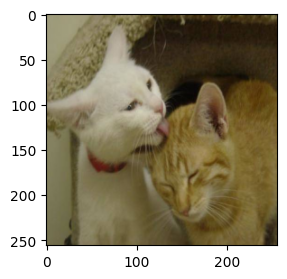

In [135]:
train_dogs_path = '/content/training_set/training_set/dogs'
train_cats_path = '/content/training_set/training_set/cats'
train_data = Dataset2class(train_dogs_path, train_cats_path, 256)

test_dogs_path = '/content/test_set/test_set/dogs'
test_cats_path = '/content/test_set/test_set/cats'
test_data = Dataset2class(test_dogs_path, test_cats_path, 256)

randomshow(train_data, 1)

## DataLoader

In [136]:
BATCH_SIZE = 24

train_loader = torch.utils.data.DataLoader(
    train_data, shuffle=True,
    batch_size=BATCH_SIZE, num_workers=1, drop_last=True)

test_loader = torch.utils.data.DataLoader(
    test_data, shuffle=True,
    batch_size=BATCH_SIZE, num_workers=1, drop_last=False)

In [137]:
for i in train_loader:
  print(i['img'].shape)
  break

torch.Size([24, 3, 256, 256])


## Architecture

In [ ]:
# model_res = tv.models.resnet.resnet34()
# model_res

In [9]:
class ResBlock(nn.Module):
    def __init__(self, nc):
        super().__init__()

        self.conv0 = nn.Conv2d(nc, nc, kernel_size=3, padding=1)
        self.norm0 = nn.BatchNorm2d(nc)
        self.act = nn.LeakyReLU(0.2)
        self.conv1 = nn.Conv2d(nc, nc, kernel_size=3, padding=1)
        self.norm1 = nn.BatchNorm2d(nc)

    def forward(self, x):
        out = self.conv0(x)
        out = self.norm0(out)
        out = self.act(out)
        out = self.conv1(out)
        out = self.norm1(out)

        return self.act(x + out)


class BottleneckBlock(nn.Module):
    def __init__(self, nc):
        super().__init__()
        self.act = nn.LeakyReLU(0.2)

        self.conv0 = nn.Conv2d(nc, nc//4, kernel_size=1, padding=0)
        self.norm0 = nn.BatchNorm2d(nc//4)
        self.conv1 = nn.Conv2d(nc//4, nc//4, kernel_size=3, padding=1)
        self.norm1 = nn.BatchNorm2d(nc//4)
        self.conv2 = nn.Conv2d(nc//4, nc, kernel_size=1, padding=0)

    def forward(self, x):
        out = self.conv0(x)
        out = self.norm0(out)
        out = self.act(out)
        out = self.conv1(out)
        out = self.norm1(out)
        out = self.act(out)
        out = self.conv2(out)

        return self.act(x + out)


class ResStack(nn.Module):
    def __init__(self, nc, num_blocks, block_type='classic'):
        super().__init__()

        stack = []
        for i in range(num_blocks):
            if block_type == 'classic':
                stack += [ResBlock(nc)]
            elif block_type == 'bottleneck':
                stack += [BottleneckBlock(nc)]

        self.stack = nn.Sequential(*stack)

    def forward(self, x):
        return self.stack(x)


class MyResNet(nn.Module):
    def __init__(self, in_nc, nc, out_nc, block_type):
        super().__init__()

        self.conv0 = nn.Conv2d(in_nc, nc, kernel_size=7, stride=2)
        self.act = nn.LeakyReLU(0.2, inplace=True)
        self.maxpool = nn.MaxPool2d(2,2)

        self.layer1 = ResStack(nc, 3, block_type=block_type)
        self.conv1 = nn.Conv2d(nc, 2*nc, 3, padding=1, stride=2)
        self.layer2 = ResStack(2*nc, 4, block_type=block_type)
        self.conv2 = nn.Conv2d(2*nc, 4*nc, 3, padding=1, stride=2)
        self.layer3 = ResStack(4*nc, 6, block_type=block_type)
        self.conv3 = nn.Conv2d(4*nc, 4*nc, 3, padding=1, stride=2)
        self.layer4 = ResStack(4*nc, 3, block_type=block_type)

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(4*nc, out_nc)

    def forward(self, x):
        out = self.conv0(x)
        out = self.act(out)
        out = self.maxpool(out)
        out = self.layer1(out)
        out = self.conv1(out)
        out = self.layer2(out)
        out = self.conv2(out)
        out = self.layer3(out)
        out = self.conv3(out)
        out = self.layer4(out)

        out = self.avgpool(out)
        out = self.flatten(out)
        out = self.linear(out)

        return out

## Train model

In [141]:
# params = {'epochs': 3,
#           'device': 'cuda',
#           'use_amp': True}

def train_mode(model, train_loader, params):
    epochs = 10
    loss_history, acc_history, test_history = [], [], []
    for epoch in range(params['epochs']):
        model.train()
        loss_val, acc_train, test_acc = 0, 0, 0
        for sample in (pbar := tqdm(train_loader)):
          img, label = sample['img'], sample['label']
          img = img.to(params['device'])
          label = label.to(params['device'])
          label = F.one_hot(label, 2).float()
          optimizer.zero_grad()
          with autocast(params['use_amp']):
            pred = model(img)
            loss = loss_function(pred, label)

          scaler.scale(loss).backward()
          loss_item = loss.item()
          loss_val += loss_item

          scaler.step(optimizer)
          scaler.update()

          acc_current = accuracy(pred.cpu().float(), label.cpu().float())
          acc_train += acc_current

          pbar.set_description(f'epoch: {epoch}\tloss: {loss_item:.5f}\taccuracy: {acc_current:.3f}')

        model.eval()
        for sample in test_loader:
            img, label = sample['img'], sample['label']
            img = img.to(params['device'])
            label = label.to(params['device'])
            label = F.one_hot(label, 2).float()
            pred = model(img)
            acc_current = accuracy(pred.cpu().float(), label.cpu().float())
            test_acc += acc_current

        test_history.append(test_acc/len(test_loader))
        loss_history.append(loss_val/len(train_loader))
        acc_history.append(acc_train/len(train_loader))
        print(f'loss: {loss_val/len(train_loader)}')
        print(f'train: {acc_train/len(train_loader)}')
        print(f'test: {test_acc/len(test_loader)}')
    return loss_history, acc_history, test_history

def accuracy(pred, label):
    answer = F.softmax(pred.detach()).numpy().argmax(1) == label.numpy().argmax(1)
    return answer.mean()

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [142]:
torch.backends.cudnn.benchmark = True
# torch.backends.cudnn.deterministic = True

model = MyResNet(3, 50, 2, 'bottleneck')
print(count_parameters(model))
model = model.to(device)
scaler = GradScaler()

loss_function = nn.CrossEntropyLoss()
loss_function = loss_function.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999))
# optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

1031656


In [149]:
params = {'epochs': 1,
          'device': 'cuda',
          'use_amp': True}

loss_history, acc_history, test_history = train_mode(model, train_loader, params)

  0%|          | 0/333 [00:00<?, ?it/s]

<ipython-input-141-ddb30a0ddf2d>:52: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  answer = F.softmax(pred.detach()).numpy().argmax(1) == label.numpy().argmax(1)


loss: 0.2796338479686249
train: 0.8846346346346349
test: 0.8091736694677869


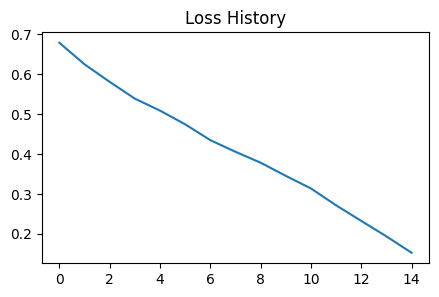

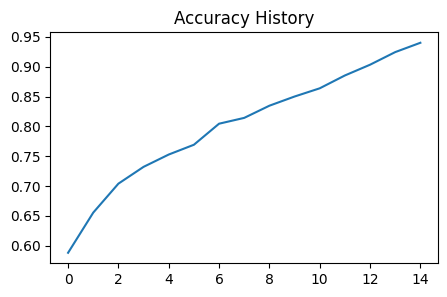

In [122]:
plt.figure(figsize=(5, 3))
plt.title('Loss History')
plt.plot(loss_history)
plt.show()
plt.figure(figsize=(5, 3))
plt.title('Accuracy History')
plt.plot(acc_history)
plt.show()

In [94]:
torch.cuda.empty_cache()